In [3]:
# Check GPU
!nvidia-smi


Thu Jul 17 09:24:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from google.colab import files
uploaded = files.upload()


Saving kaggle (1).json to kaggle (1).json


In [12]:
!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
!pip install -q kaggle


In [14]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 595MB/s]


In [15]:
!unzip brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_data


Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_data/brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_data/bra

In [16]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

IMG_SIZE = 150
data = []
labels = []

# Dataset path
DATA_DIR = '/content/brain_tumor_data/brain_tumor_dataset'

for category in ['yes', 'no']:
    path = os.path.join(DATA_DIR, category)
    label = 1 if category == 'yes' else 0
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(label)
        except:
            pass

# Convert and normalize
data = np.array(data) / 255.0
data = np.expand_dims(data, axis=-1)
labels = np.array(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,635,905 (40.57 MB)

 Trainable params: 10,635,905 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6081 - loss: 0.7454 - val_accuracy: 0.7255 - val_loss: 0.6072
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7702 - loss: 0.4545 - val_accuracy: 0.6863 - val_loss: 0.5687
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8318 - loss: 0.4140 - val_accuracy: 0.7843 - val_loss: 0.5296
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8740 - loss: 0.3003 - val_accuracy: 0.8039 - val_loss: 0.4813
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9172 - loss: 0.2271 - val_accuracy: 0.8627 - val_loss: 0.3985
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9413 - loss: 0.1579 - val_accuracy: 0.8627 - val_loss: 0.4097
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9724 - loss: 0.0770 - val_accuracy: 0.8824 - val_loss: 0.4524
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9988 - loss: 0.0450 - val_accuracy: 0.8235 - val_loss: 0.4802


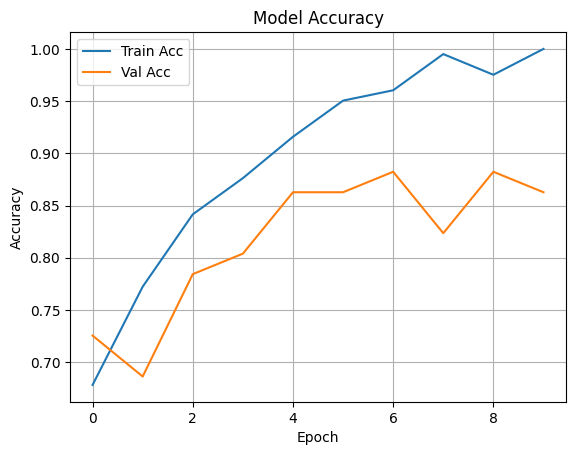

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

# Train using generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6466 - loss: 0.7971 - val_accuracy: 0.8431 - val_loss: 0.4572
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7102 - loss: 0.5700 - val_accuracy: 0.7451 - val_loss: 0.5626
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7132 - loss: 0.6028 - val_accuracy: 0.7647 - val_loss: 0.5653
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7666 - loss: 0.4778 - val_accuracy: 0.7451 - val_loss: 0.5631
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8055 - loss: 0.5051 - val_accuracy: 0.8431 - val_loss: 0.5468
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8302 - loss: 0.4003 - val_accuracy: 0.8235 - val_loss: 0.7108
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7788 - loss: 0.5186 - val_accuracy: 0.8235 - val_loss: 0.5657
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7922 - loss: 0.4888 - val_accuracy: 0.8235 - val_loss: 0.5286
Epoch 9/10


In [21]:
from tensorflow.keras.regularizers import l2

# Example layer with L2
Dense(128, activation='relu', kernel_regularizer=l2(0.001))


<Dense name=dense_2, built=False>

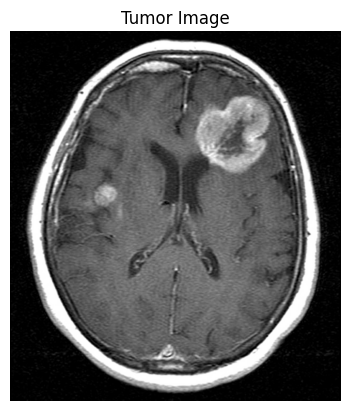

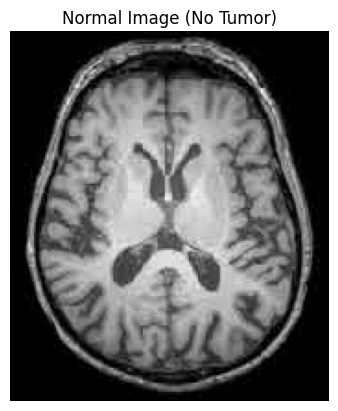

In [22]:
# Show sample images with tumor
import matplotlib.pyplot as plt
import cv2
import os

tumor_path = "/content/brain_tumor_data/brain_tumor_dataset/yes"
normal_path = "/content/brain_tumor_data/brain_tumor_dataset/no"

# Display tumor image
tumor_img = cv2.imread(os.path.join(tumor_path, os.listdir(tumor_path)[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(tumor_img, cmap='gray')
plt.title("Tumor Image")
plt.axis('off')
plt.show()

# Display normal image
normal_img = cv2.imread(os.path.join(normal_path, os.listdir(normal_path)[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(normal_img, cmap='gray')
plt.title("Normal Image (No Tumor)")
plt.axis('off')
plt.show()


In [23]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model (skip if already loaded)
# model = load_model("tumor_model.h5")

def predict_mri(image_path):
    IMG_SIZE = 150
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel
    img = np.expand_dims(img, axis=0)   # Add batch dim

    prediction = model.predict(img)[0][0]
    if prediction > 0.5:
        print("🔴 Tumor Detected")
    else:
        print("🟢 No Tumor Detected")

# Example usage
predict_mri("your_uploaded_image.jpg")


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [24]:
!wget -O tumor.jpg "https://github.com/bharathgs/AIML-Projects/raw/master/Brain%20Tumor%20Detection/yes/Y1.jpg"
!wget -O normal.jpg "https://github.com/bharathgs/AIML-Projects/raw/master/Brain%20Tumor%20Detection/no/N1.jpg"


--2025-07-17 09:29:13--  https://github.com/bharathgs/AIML-Projects/raw/master/Brain%20Tumor%20Detection/yes/Y1.jpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-17 09:29:14 ERROR 404: Not Found.

--2025-07-17 09:29:14--  https://github.com/bharathgs/AIML-Projects/raw/master/Brain%20Tumor%20Detection/no/N1.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-17 09:29:14 ERROR 404: Not Found.



In [25]:
predict_mri("tumor.jpg")   # 🔴 Tumor Detected
predict_mri("normal.jpg")  # 🟢 No Tumor Detected


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [26]:
def predict_mri(image_path):
    IMG_SIZE = 150
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"❌ Error: Could not load image at path: {image_path}")
        return

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    if prediction > 0.5:
        print("🔴 Tumor Detected")
    else:
        print("🟢 No Tumor Detected")

# Download tumor and normal images
!wget -O tumor.jpg https://raw.githubusercontent.com/bharathgs/AIML-Projects/master/Brain%20Tumor%20Detection/yes/Y1.jpg
!wget -O normal.jpg https://raw.githubusercontent.com/bharathgs/AIML-Projects/master/Brain%20Tumor%20Detection/no/N1.jpg
predict_mri("tumor.jpg")
predict_mri("normal.jpg")



--2025-07-17 09:29:20--  https://raw.githubusercontent.com/bharathgs/AIML-Projects/master/Brain%20Tumor%20Detection/yes/Y1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-17 09:29:20 ERROR 404: Not Found.

--2025-07-17 09:29:20--  https://raw.githubusercontent.com/bharathgs/AIML-Projects/master/Brain%20Tumor%20Detection/no/N1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-17 09:29:20 ERROR 404: Not Found.

❌ Error: Could not load image at path: tumor.jpg
❌ Error: Could not load image at path: normal.jpg


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model (skip if already loaded)
# model = load_model("tumor_model.h5")

def predict_mri(image_path):
    IMG_SIZE = 150
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel
    img = np.expand_dims(img, axis=0)   # Add batch dim

    prediction = model.predict(img)[0][0]
    if prediction > 0.5:
        print("🔴 Tumor Detected")
    else:
        print("🟢 No Tumor Detected")

# Example usage
predict_mri("images (10).jpeg.jpg")  # ← This will print either "Tumor" or "No Tumor"


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2d_1"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [28]:
def preprocess_for_gradcam(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img


In [29]:
def display_gradcam(image_path, model, last_conv_layer="conv2d_1", alpha=0.4):
    img_array = preprocess_for_gradcam(image_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # Convert grayscale to RGB for overlay
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Display
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img[..., ::-1])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_img[..., ::-1])
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.show()


In [30]:
display_gradcam("download (4).jpeg.jpg", model)


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [31]:
_ = model.predict(np.zeros((1, 150, 150, 1)))  # dummy input


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


In [32]:
display_gradcam("download (4).jpeg.jpg", model)


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
from google.colab import files
uploaded = files.upload()


In [33]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("download (4).jpeg.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Uploaded MRI Image")
plt.show()


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# Trigger dummy prediction to "build" the model
_ = model.predict(np.zeros((1, 150, 150, 1)))

# Run Grad-CAM on uploaded image
display_gradcam("download (4).jpeg.jpg", model, last_conv_layer="conv2d_1")


In [34]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train just 1 epoch to build the model
model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.6313 - loss: 1.0947 - val_accuracy: 0.7059 - val_loss: 0.5901


In [ ]:
display_gradcam("download (4).jpeg.jpg", model, last_conv_layer="conv2d_1")


In [ ]:
_ = model.predict(np.zeros((1, 150, 150, 1)))  # builds the model


In [ ]:
display_gradcam("download (4).jpeg.jpg", model, last_conv_layer="conv2d_3")


In [ ]:
import numpy as np

# Run this to "build" the model
_ = model.predict(np.zeros((1, 150, 150, 1)))


In [ ]:
for layer in model.layers:
    print(layer.name)


In [ ]:
display_gradcam("download (4).jpeg.jpg", model, last_conv_layer="conv2d_3")


In [ ]:
model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))


In [ ]:
display_gradcam("download (4).jpeg.jpg", model, last_conv_layer="conv2d_3")


In [ ]:
!pip install -q gradio


In [35]:
import gradio as gr
import cv2

def classify_mri(img):
    IMG_SIZE = 150
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0][0]
    label = "🔴 Tumor Detected" if pred > 0.5 else "🟢 No Tumor Detected"
    confidence = f"Confidence: {round(float(pred if pred > 0.5 else 1 - pred)*100, 2)}%"
    return label + "\n" + confidence


In [ ]:
interface = gr.Interface(
    fn=classify_mri,
    inputs=gr.Image(type="numpy", label="Upload Brain MRI"),
    outputs=gr.Textbox(label="Prediction"),
    title="🧠 Brain Tumor Detector",
    description="Upload an MRI image and get instant prediction (Tumor / No Tumor)"
)

interface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://85646697253a268c11.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
